
Primera fase: cargar el Dataset de informacion general y realizar limpieza





In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Revisar tamaño del dataset y columnas

In [70]:
import pandas as pd
# Cargar el dataset de Informacion global
df = pd.read_csv( "/content/drive/MyDrive/X_Rays_images/raw/Data_Entry_2017.csv", encoding="utf-8")
print( df.shape)
print("Columnas:", df.columns.tolist())
df.head()

(112120, 12)
Columnas: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


Revisar datos nilos del dataset



In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


Existe una columna sin datos y columnas como  "OriginalImagePixelSpacing[x", "y]", "OriginalImage[Width", "Height]" son irrelevantes para el caso ya que las imagenes se van a redimensionar a 224 x 224 pixeles, esta indormación seria necesaria en caso de realizar segmentación o medición antomica, las patologias que se buscan identificar se encuentran mediante patrones visuales


In [72]:
cols_eliminar = ["Unnamed: 11", "OriginalImagePixelSpacing[x", "y]", "OriginalImage[Width", "Height]"]

df.drop(columns=cols_eliminar, inplace=True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


**REVISIÓN DE COLUMNAS NUMÉRICAS**

Revisión estadisticas del dataset


In [73]:
df.describe()

,Follow-up #,Patient ID,Patient Age
count,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463
std,15.406320,8403.876972,16.839923
min,0.000000,1.000000,1.000000
25%,0.000000,7310.750000,35.000000
50%,3.000000,13993.000000,49.000000
75%,10.000000,20673.000000,59.000000
max,183.000000,30805.000000,414.000000


# **Existe una gran dispersion de datos, debemos identificar outliers por columnas numéricas**







Primero vamos a revisar estos utliers utilizando rangos intercuartilicos

Columna: Follow-up #
Cantidad de outliers: 10182
Valores outliers:
[26 27 28 ... 54 55 26]

Columna: Patient ID
Cantidad de outliers: 0
Valores outliers:
[]

Columna: Patient Age
Cantidad de outliers: 16
Valores outliers:
[412 414 148 148 150 149 152 151 411 412 413 412 153 154 155 155]



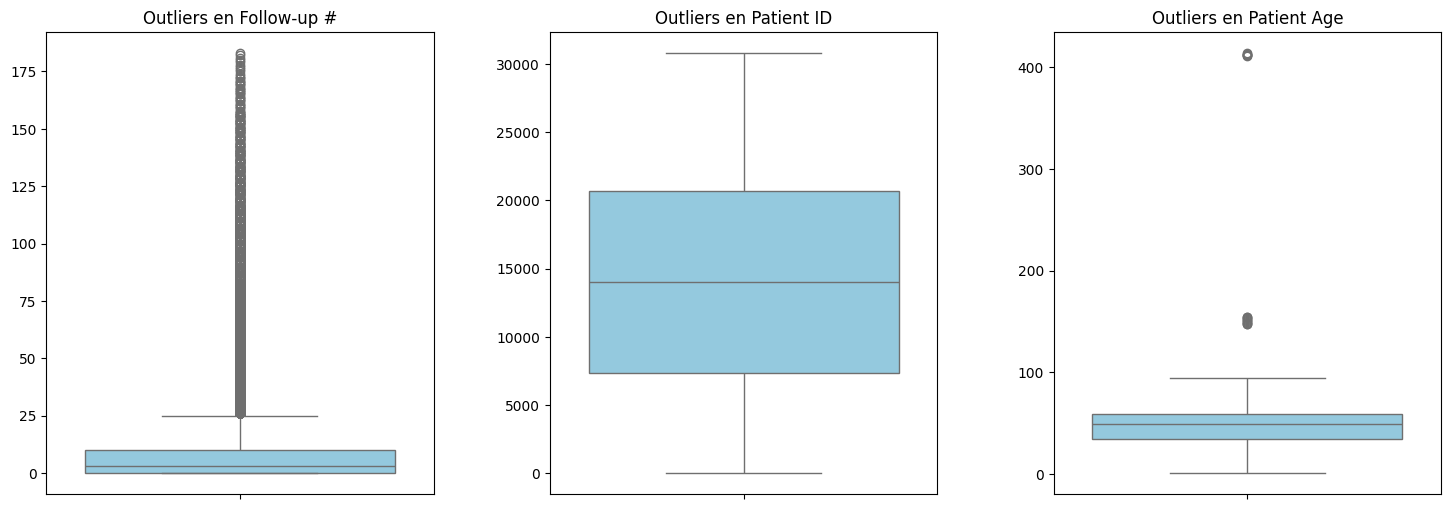

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columnas_numericas = ["Follow-up #", "Patient ID", "Patient Age"]

# Función para detectar outliers usando IQR
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    # Outliers: < Q1 - 1.5*IQR o > Q3 + 1.5*IQR
    outliers = df[(df[columna] < Q1 - 1.5*IQR) | (df[columna] > Q3 + 1.5*IQR)]
    return outliers

# Resumen de outliers
for col in columnas_numericas:
    outliers_col = detectar_outliers(df, col)
    print(f"Columna: {col}")
    print(f"Cantidad de outliers: {len(outliers_col)}")
    print(f"Valores outliers:\n{outliers_col[col].values}\n")

# Graficas en un dashboard más compacto: 1 fila, 3 columnas
fig, ax = plt.subplots(nrows=1, ncols=len(columnas_numericas), figsize=(18, 6))
fig.subplots_adjust(wspace=0.3)

for i, col in enumerate(columnas_numericas):
    sns.boxplot(y=df[col], ax=ax[i], color="skyblue")
    ax[i].set_title(f"Outliers en {col}")
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

plt.show()


La mayoría de los datos están concentrados en rangos pequeños y “normales” para estas columnas.

La columna Follow-up # tiene una gran cantidad de valores extremadamente altos

La columna Patient ID es correcta y no tiene outliers

La columna Patient Age muestra algunos valores imposibles que deben ser corregidos o eliminados.

Para identificar si la columna follow - up tiene errores de digitación
se va a implementar una funcion que identifique por paciente irregularidades


In [75]:
import numpy as np
import pandas as pd

def check_consecutive_followups(df, patient_col='Patient ID', followup_col='Follow-up #'):
    """
    Detecta pacientes cuyos Follow-up # no son consecutivos.
    Imprime Patient ID y los gaps encontrados.
    """
    df_local = df.copy()
    df_local[followup_col] = pd.to_numeric(df_local[followup_col], errors='coerce')

    # Agrupar por paciente
    grouped = df_local.groupby(patient_col)[followup_col].apply(lambda x: np.sort(x.dropna().unique()))

    patients_with_gaps = {}

    for pid, follow_vals in grouped.items():
        if len(follow_vals) == 0:
            continue  # paciente sin follow-ups
        diffs = np.diff(follow_vals)
        if np.any(diffs > 1):  # gap detectado
            # Guardar los detalles de los gaps
            gap_details = [(follow_vals[i], follow_vals[i+1], diffs[i])
                           for i in range(len(diffs)) if diffs[i] > 1]
            patients_with_gaps[pid] = gap_details

    # Imprimir resultados
    if not patients_with_gaps:
        print("Todos los pacientes tienen follow-ups consecutivos.")
        return

    print(f"Pacientes con follow-ups no consecutivos: {len(patients_with_gaps)}\n")
    for pid, gaps in patients_with_gaps.items():
        print(f"Patient ID: {pid}")
        for a, b, gap in gaps:
            print(f"  Gap: {a} -> {b}, salto {gap}")
        print("-"*40)

# Ejemplo de uso
check_consecutive_followups(df)


Todos los pacientes tienen follow-ups consecutivos.


Podemos confirmar que los outliers no son por errores de digitación , existen pacientes con una gran cantidad de seguimientos


In [76]:
import pandas as pd

# Contar la cantidad de follow-ups por paciente
followup_counts = df.groupby('Patient ID')['Follow-up #'].count()

# Filtrar pacientes con más de 20 follow-ups
patients_over_20 = followup_counts[followup_counts > 20]

# Mostrar resultados
print(f"Total pacientes: {followup_counts.size}")
print(f"Pacientes con más de 20 follow-ups: {patients_over_20.size}")
print("\nEjemplo de pacientes con más de 20 follow-ups:")
print(patients_over_20.head())


Total pacientes: 30805
Pacientes con más de 20 follow-ups: 803

Ejemplo de pacientes con más de 20 follow-ups:
Patient ID
13     47
32     61
61     26
116    41
181    66
Name: Follow-up #, dtype: int64


Podemos ver que la cantidad de pacientes con outliers no es muy representativa, se van a conservar máximo 25  seguimientos por paciente para evitar outliers


In [77]:
import pandas as pd

def remove_followup_outliers(df, followup_col='Follow-up #', threshold=25):
    # Convertir a numérico
    df[followup_col] = pd.to_numeric(df[followup_col], errors='coerce')

    print("========= ANTES DE ELIMINAR =========")
    print(f"Tamaño original del dataset: {df.shape[0]} filas")
    print(f"Valores negativos: {(df[followup_col] < 0).sum()}")
    print(f"Valores mayores a {threshold}: {(df[followup_col] > threshold).sum()}")

    # Filas a eliminar según el umbral
    rows_to_remove = df[df[followup_col] > threshold]
    print("\n========= FILAS A ELIMINAR =========")
    print(rows_to_remove[[followup_col, 'Patient ID']].head())
    print(f"Total filas eliminadas: {rows_to_remove.shape[0]}")
    print(f"Pacientes afectados : {rows_to_remove['Patient ID'].nunique()}")

    # Eliminar las filas directamente del df original
    df.drop(rows_to_remove.index, inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("\n========= DESPUÉS DE ELIMINAR =========")
    print(f"Tamaño del dataset limpio: {df.shape[0]} filas")

    # Revisar outliers estadísticos (IQR) dentro del dataset filtrado
    followups = df[followup_col]
    q1 = followups.quantile(0.25)
    q3 = followups.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = followups[(followups < lower) | (followups > upper)]
    print(f"Número de outliers estadísticos restantes: {outliers.shape[0]}")
    print(f"Rango aceptable según IQR: [{lower:.1f}, {upper:.1f}]")

# Uso
remove_followup_outliers(df)


========= ANTES DE ELIMINAR =========
Tamaño original del dataset: 112120 filas
Valores negativos: 0
Valores mayores a 25: 10182

========= FILAS A ELIMINAR =========
    Follow-up #  Patient ID
64           26          13
65           27          13
66           28          13
67           29          13
68           30          13
Total filas eliminadas: 10182
Pacientes afectados : 515

========= DESPUÉS DE ELIMINAR =========
Tamaño del dataset limpio: 101938 filas
Número de outliers estadísticos restantes: 5856
Rango aceptable según IQR: [-10.5, 17.5]


Eliminación de outliers columna edad

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101938 entries, 0 to 101937
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Image Index     101938 non-null  object
 1   Finding Labels  101938 non-null  object
 2   Follow-up #     101938 non-null  int64 
 3   Patient ID      101938 non-null  int64 
 4   Patient Age     101938 non-null  int64 
 5   Patient Gender  101938 non-null  object
 6   View Position   101938 non-null  object
dtypes: int64(3), object(4)
memory usage: 5.4+ MB


In [79]:
# Mostrar outliers antes de limpiar
out_of_bounds = df[(df['Patient Age'] < 0) | (df['Patient Age'] > 95)]
print("Outliers de Patient Age detectados antes de limpieza:")
print(out_of_bounds[['Patient Age', 'Patient ID']])

# Eliminar del dataset original
df.drop(out_of_bounds.index, inplace=True)
df.reset_index(drop=True, inplace=True)


Outliers de Patient Age detectados antes de limpieza:
       Patient Age  Patient ID
19282          412        5567
42992          414       11973
44108          148       12238
50505          148       13950
56932          149       15558
70854          151       19346
76264          411       20900
76795          412       21047
77567          413       21275
82361          412       22811
86586          153       25206
89066          154       26028
91566          155       26871
94694          155       27989


Al eliminar los valores atípicos de Follow - up # los valores atípicos de patient age tambien fueron eliminados

Exploración de columnas categoricas del dataset, filtración por enfermedades mas comunes

In [80]:
import pandas as pd

# Lista de enfermedades que se están estudiando
enfermedades_objetivo = ['No Finding', 'Infiltration', 'Atelectasis', 'Effusion', 'Nodule']

# Función para filtrar solo las enfermedades de interés
def filtrar_enfermedades(label):
    # Dividir por '|' si hay combinaciones
    etiquetas = label.split('|')
    # Mantener solo las que estén en la lista de interés
    etiquetas_filtradas = [e for e in etiquetas if e in enfermedades_objetivo]
    if len(etiquetas_filtradas) == 0:
        return 'No Target Disease'
    return '|'.join(etiquetas_filtradas)

# Aplicar la función al dataset
df['Finding Labels'] = df['Finding Labels'].apply(filtrar_enfermedades)

# Contar cuántas filas no tienen ninguna de las enfermedades objetivo
no_target_count = (df['Finding Labels'] == 'No Target Disease').sum()

print("="*60)
print("Resumen después de filtrar enfermedades de interés")
print("="*60)
print(f"Filas totales ANTES de eliminar: {len(df)}")
print(f"Filas sin ninguna de las enfermedades estudiadas: {no_target_count}")
print(f"Porcentaje: {no_target_count / len(df) * 100:.2f}%")

# ELIMINAR FILAS "No Target Disease"
df = df[df['Finding Labels'] != 'No Target Disease'].reset_index(drop=True)

print("\nFilas totales DESPUÉS de eliminar:", len(df))

# Mostrar las 10 combinaciones más frecuentes de las enfermedades objetivo
print("\nTop 10 combinaciones de enfermedades estudiadas:")
top_combinations = df['Finding Labels'].value_counts().head(10)
for label, count in top_combinations.items():
    pct = count / len(df) * 100
    print(f"{label:30} : {count:6} ({pct:5.2f}%)")


Resumen después de filtrar enfermedades de interés
Filas totales ANTES de eliminar: 101924
Filas sin ninguna de las enfermedades estudiadas: 10836
Porcentaje: 10.63%

Filas totales DESPUÉS de eliminar: 91088

Top 10 combinaciones de enfermedades estudiadas:
No Finding                     :  56951 (62.52%)
Infiltration                   :  10635 (11.68%)
Effusion                       :   5857 ( 6.43%)
Atelectasis                    :   5512 ( 6.05%)
Nodule                         :   3593 ( 3.94%)
Effusion|Infiltration          :   2012 ( 2.21%)
Atelectasis|Effusion           :   1690 ( 1.86%)
Atelectasis|Infiltration       :   1687 ( 1.85%)
Infiltration|Nodule            :    992 ( 1.09%)
Atelectasis|Effusion|Infiltration :    984 ( 1.08%)


Podemos notar que el dataset esta altamente desbalanceado

Para tratar el desbalance de estas enfermedades se van a aplicar pesos para darle mayor prioridad a enfermedades con pocos datos


In [81]:
# Distribución de Patient Gender
gender_counts = df['Patient Gender'].value_counts()
gender_percent = df['Patient Gender'].value_counts(normalize=True) * 100

print("============================================================")
print("Distribución de Patient Gender")
print("============================================================")
for g, count in gender_counts.items():
    print(f"{g}: {count} ({gender_percent[g]:.2f}%)")
print("\n")

# Distribución de View Position
view_counts = df['View Position'].value_counts()
view_percent = df['View Position'].value_counts(normalize=True) * 100

print("============================================================")
print("Distribución de View Position")
print("============================================================")
for v, count in view_counts.items():
    print(f"{v}: {count} ({view_percent[v]:.2f}%)")


Distribución de Patient Gender
M: 51682 (56.74%)
F: 39406 (43.26%)


Distribución de View Position
PA: 57991 (63.66%)
AP: 33097 (36.34%)


La distribución por género esta correctamente balanceada

In [82]:
import pandas as pd


target_diseases = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule"]

def replace_other_diseases(finding):
    # Split para manejar combinaciones múltiples de enfermedades
    diseases = finding.split("|")
    # Solo mantenemos las que estén en target_diseases
    filtered = [d for d in diseases if d in target_diseases]
    if not filtered:  # si ninguna coincide, reemplazamos por "Other Disease"
        return "Other Disease"
    else:
        return "|".join(filtered)

# Aplicamos la función
df["Finding Labels"] = df["Finding Labels"].apply(replace_other_diseases)

# Verificación rápida
print(df["Finding Labels"].value_counts())


Finding Labels
No Finding                                  56951
Infiltration                                10635
Effusion                                     5857
Atelectasis                                  5512
Nodule                                       3593
Effusion|Infiltration                        2012
Atelectasis|Effusion                         1690
Atelectasis|Infiltration                     1687
Infiltration|Nodule                           992
Atelectasis|Effusion|Infiltration             984
Effusion|Nodule                               444
Atelectasis|Nodule                            289
Effusion|Infiltration|Nodule                  181
Atelectasis|Effusion|Nodule                   102
Atelectasis|Infiltration|Nodule                86
Atelectasis|Effusion|Infiltration|Nodule       61
Nodule|Atelectasis                              3
Infiltration|Atelectasis                        2
Effusion|Infiltration|Atelectasis               2
Effusion|Atelectasis               

In [83]:
# Lista de enfermedades de interés
target_diseases = ['no finding', 'infiltration', 'atelectasis', 'effusion', 'nodule']

# Función para normalizar cada fila
def normalize_label(label):
    # Convertir a minúscula y separar por '|'
    parts = [x.strip().lower() for x in label.split('|')]
    # Mantener solo enfermedades de interés
    parts = [x if x in target_diseases else 'other disease' for x in parts]
    # Eliminar duplicados y ordenar
    parts = sorted(list(set(parts)))
    # Unir de nuevo
    return '|'.join(parts)

# Aplicar sobre la columna
df['Finding Labels'] = df['Finding Labels'].apply(normalize_label)

# Contar combinaciones resultantes
combinations_count = df['Finding Labels'].value_counts()

print(combinations_count)


Finding Labels
no finding                                  56951
infiltration                                10635
effusion                                     5857
atelectasis                                  5512
nodule                                       3593
effusion|infiltration                        2012
atelectasis|effusion                         1692
atelectasis|infiltration                     1689
infiltration|nodule                           992
atelectasis|effusion|infiltration             986
effusion|nodule                               444
atelectasis|nodule                            292
effusion|infiltration|nodule                  183
atelectasis|effusion|nodule                   103
atelectasis|infiltration|nodule                86
atelectasis|effusion|infiltration|nodule       61
Name: count, dtype: int64


Se organizaron las combinaciones de enfermedades por orden alfabetico y cada etiqueta se llevo a minuscula


In [84]:
# Lista de enfermedades de interés
enfermedades = ['no finding', 'infiltration', 'atelectasis', 'effusion', 'nodule', 'other disease']

# Creamos las columnas para cada enfermedad
for enfermedad in enfermedades:
    # La columna será 1 si aparece la enfermedad en 'Finding Labels', 0 si no
    df[enfermedad] = df['Finding Labels'].apply(lambda x: 1 if enfermedad in x.split('|') else 0)

# Verificación
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,no finding,infiltration,atelectasis,effusion,nodule,other disease
0,00000001_002.png,effusion,2,1,58,M,PA,0,0,0,1,0,0
1,00000002_000.png,no finding,0,2,81,M,PA,1,0,0,0,0,0
2,00000003_003.png,infiltration,3,3,76,F,PA,0,1,0,0,0,0
3,00000004_000.png,nodule,0,4,82,M,AP,0,0,0,0,1,0
4,00000005_000.png,no finding,0,5,69,F,PA,1,0,0,0,0,0


Se implemento one hot encoding por cada etiqueta

Se reviso que cada imagen estuviera asociada a un seguimiento

In [85]:
# Revisar duplicados por paciente y follow-up
duplicados = df.duplicated(subset=['Patient ID', 'Follow-up #'], keep=False)

# Filas duplicadas
df_duplicates = df[duplicados].sort_values(['Patient ID', 'Follow-up #'])

# Número de pacientes afectados
pacientes_afectados = df_duplicates['Patient ID'].nunique()

print(f"Total de imágenes duplicadas por paciente y follow-up: {df_duplicates.shape[0]}")
print(f"Número de pacientes con duplicados: {pacientes_afectados}")

# Mostrar algunos ejemplos
df_duplicates.head(10)


Total de imágenes duplicadas por paciente y follow-up: 0
Número de pacientes con duplicados: 0


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,no finding,infiltration,atelectasis,effusion,nodule,other disease


In [86]:
# Revisar la distribución de vistas antes
print("Distribución de vistas antes del filtrado:")
print(df["View Position"].value_counts())

# Guardar total antes del filtrado
total_antes = len(df)

# Filtrar solo PA
df = df[df["View Position"] == "PA"].copy()

# Total después del filtrado
total_despues = len(df)

# Calcular eliminadas y porcentaje
eliminadas = total_antes - total_despues
porcentaje = (eliminadas / total_antes) * 100

print("\nFilas totales antes:", total_antes)
print("Filas después (solo PA):", total_despues)
print("Filas eliminadas:", eliminadas)
print("Porcentaje eliminado: {:.2f}%".format(porcentaje))

# ELIMINAR LA COLUMNA "View Position"
df = df.drop(columns=["View Position"])

print("\nColumna 'View Position' eliminada. Columnas actuales del dataframe:")
print(df.columns.tolist())


Distribución de vistas antes del filtrado:
View Position
PA    57991
AP    33097
Name: count, dtype: int64

Filas totales antes: 91088
Filas después (solo PA): 57991
Filas eliminadas: 33097
Porcentaje eliminado: 36.34%

Columna 'View Position' eliminada. Columnas actuales del dataframe:
['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'no finding', 'infiltration', 'atelectasis', 'effusion', 'nodule', 'other disease']


Verificar imagenes en la carpeta



In [87]:
import os
import pandas as pd


# Carpeta base
base_path = '/content/drive/MyDrive/X_Rays_images/raw/'

# Crear lista de todas las imágenes en las subcarpetas
all_images = []

for i in range(1, 13):
    folder_name = f'images_{i:03d}/images'  # images_001/images, etc.
    full_path = os.path.join(base_path, folder_name)

    if os.path.exists(full_path):
        for file in os.listdir(full_path):
            if file.endswith('.png'):
                all_images.append(file)
    else:
        print(f"Carpeta no encontrada: {full_path}")

all_images_set = set(all_images)
df_images_set = set(df['Image Index'])  # aseguramos que tengan extensión

# Imágenes que sobran en las carpetas (no están en df)
extra_images = all_images_set - df_images_set
# Imágenes que faltan (están en df pero no en carpetas)
missing_images = df_images_set - all_images_set

print(f"Total de imágenes en carpetas: {len(all_images_set)}")
print(f"Total de imágenes en dataframe: {len(df_images_set)}")
print(f"Imágenes sobrantes en carpetas: {len(extra_images)}")
print(f"Imágenes faltantes en carpetas: {len(missing_images)}")

# Eliminar filas con imágenes faltantes
df_limpio = df[~df['Image Index'].isin(missing_images)]
df= df_limpio


# Imprimir cuántas filas quedaron
print(f"Filas restantes en el dataset después de eliminar imágenes faltantes: {len(df_limpio)}")


Total de imágenes en carpetas: 106015
Total de imágenes en dataframe: 57991
Imágenes sobrantes en carpetas: 51286
Imágenes faltantes en carpetas: 3262
Filas restantes en el dataset después de eliminar imágenes faltantes: 54729


Redimensionar imagenes para la carpeta


In [88]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,no finding,infiltration,atelectasis,effusion,nodule,other disease
0,00000001_002.png,effusion,2,1,58,M,0,0,0,1,0,0
1,00000002_000.png,no finding,0,2,81,M,1,0,0,0,0,0
2,00000003_003.png,infiltration,3,3,76,F,0,1,0,0,0,0
4,00000005_000.png,no finding,0,5,69,F,1,0,0,0,0,0
7,00000005_003.png,no finding,3,5,69,F,1,0,0,0,0,0


Analisis exploratorio basico

In [89]:
# Contar cuántas veces aparece "Other Disease" en 'Finding Labels'
other_count = df['Finding Labels'].str.contains('other disease', na=False).sum()

print(f'"other Disease" aparece {other_count} veces en Finding Labels')

# Si no aparece, eliminar columna 'Other Disease' si existe
if other_count == 0 and 'other disease' in df.columns:
    df = df.drop(columns=['other disease'])
    print("Columna 'other Disease' eliminada porque no tenía registros.")
else:
    print("Columna 'other Disease' se mantiene.")


"other Disease" aparece 0 veces en Finding Labels
Columna 'other Disease' eliminada porque no tenía registros.


In [90]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Lista de etiquetas
label_cols = ['no finding','infiltration','atelectasis','effusion','nodule']

# Crear figura con subplots: 3 filas, 2 columnas
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Distribución de Edad",
        "Distribución de Género",
        "Distribución de seguimientos",
        "Distribución de Etiquetas",
        "Correlación entre Etiquetas",
        "cantidad de seguimientos por Paciente"
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# -------------------------------
# 1️Edad
age_hist = go.Histogram(x=df['Patient Age'], nbinsx=20, name='Edad', marker_color='skyblue')
fig.add_trace(age_hist, row=1, col=1)

# 2 Género
gender_counts = df['Patient Gender'].value_counts()
gender_bar = go.Bar(x=gender_counts.index, y=gender_counts.values, name='Género', marker_color='lightgreen')
fig.add_trace(gender_bar, row=1, col=2)

# 3️Follow-ups
followup_hist = go.Histogram(x=df['Follow-up #'], nbinsx=25, name='Follow-up', marker_color='salmon')
fig.add_trace(followup_hist, row=2, col=1)

# 4️Etiquetas (mostramos sumatoria de cada etiqueta)
label_sums = df[label_cols].sum().sort_values(ascending=False)
label_bar = go.Bar(x=label_sums.index, y=label_sums.values, name='Etiquetas', marker_color='orange')
fig.add_trace(label_bar, row=2, col=2)

# 5️ Correlación entre etiquetas
import numpy as np
corr = df[label_cols].corr().values
corr_heatmap = go.Heatmap(z=corr, x=label_cols, y=label_cols, colorscale='Viridis', zmin=-1, zmax=1)
fig.add_trace(corr_heatmap, row=3, col=1)

# 6️Follow-ups por paciente
followup_counts = df.groupby('Patient ID')['Follow-up #'].nunique().reset_index()
followup_patient_hist = go.Histogram(x=followup_counts['Follow-up #'], nbinsx=20, name='Follow-ups por Paciente', marker_color='purple')
fig.add_trace(followup_patient_hist, row=3, col=2)

# -------------------------------
# Layout general
fig.update_layout(
    height=1200, width=1000,
    title_text="Dashboard Exploratorio de Radiografías",
    showlegend=False
)

fig.show()


In [91]:
# Renombrar columna
if 'no finding' in df.columns:
    df = df.rename(columns={'no finding': 'other disease'})
    print("Columna 'No Finding' renombrada a 'Other Disease'.")
else:
    print("La columna 'No Finding' no existe en el dataframe.")


Columna 'No Finding' renombrada a 'Other Disease'.


In [92]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,other disease,infiltration,atelectasis,effusion,nodule
0,00000001_002.png,effusion,2,1,58,M,0,0,0,1,0
1,00000002_000.png,no finding,0,2,81,M,1,0,0,0,0
2,00000003_003.png,infiltration,3,3,76,F,0,1,0,0,0
4,00000005_000.png,no finding,0,5,69,F,1,0,0,0,0
7,00000005_003.png,no finding,3,5,69,F,1,0,0,0,0


In [93]:
# Carpeta destino
output_path = '/content/drive/MyDrive/X_Rays_images/CleanData/dataset_limpio.csv'

# Exportar el dataframe limpio a CSV
df.to_csv(output_path, index=False)

print(f"Dataset limpio exportado correctamente a:\n{output_path}")


Dataset limpio exportado correctamente a:
/content/drive/MyDrive/X_Rays_images/CleanData/dataset_limpio.csv


In [93]:
import os
from PIL import Image
from tqdm import tqdm  # para barra de progreso

# Carpeta de origen
base_path = '/content/drive/MyDrive/X_Rays_images/raw/'

# Carpetas finales
output_folder = '/content/drive/MyDrive/X_Rays_images/CleanData/imagenes_procesadas'
os.makedirs(output_folder, exist_ok=True)

# Tamaño objetivo
target_size = (224, 224)

# Procesar cada imagen que está en el dataframe limpio
for img_name in tqdm(df['Image Index'], desc="Procesando imágenes"):
    # Determinar en qué subcarpeta está la imagen
    found = False
    for i in range(1, 13):
        folder_path = os.path.join(base_path, f'images_{i:03d}/images')
        img_path = os.path.join(folder_path, img_name)
        if os.path.exists(img_path):
            # Abrir, redimensionar y guardar
            img = Image.open(img_path).convert('RGB')  # asegurar 3 canales
            img_resized = img.resize(target_size)
            img_resized.save(os.path.join(output_folder, img_name))
            found = True
            break
    if not found:
        print(f"Imagen no encontrada: {img_name}")

# Verificación final
processed_images = set(os.listdir(output_folder))
df_images_set = set(df['Image Index'])

extra_images = processed_images - df_images_set
missing_images = df_images_set - processed_images

print("\n===== Verificación final =====")
print(f"Total imágenes procesadas: {len(processed_images)}")
print(f"Imágenes sobrantes: {len(extra_images)}")
print(f"Imágenes faltantes: {len(missing_images)}")

if missing_images:
    print("Ejemplos de imágenes faltantes:", list(missing_images)[:10])
if extra_images:
    print("Ejemplos de imágenes sobrantes:", list(extra_images)[:10])
